In [4]:
import os
from os.path import isfile, join, abspath, basename
from optparse import OptionParser
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import sqlalchemy
import json

import sys
parentdir = os.path.abspath('/home/xcheng/mvesc/ETL')
sys.path.insert(0,parentdir)
from mvesc_utility_functions import *

import inspect
import datetime
from itertools import chain, groupby
import matplotlib.pyplot as plt
import matplotlib
from pandas.tools.plotting import table

matplotlib.style.use('ggplot')
get_ipython().magic('matplotlib')
from mvesc_utility_functions import *
%load_ext autotime
%matplotlib inline

Using matplotlib backend: agg
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 20.8 ms


# Planning: what features to include

1. Aggregate absence rate days;
2. 

In [55]:
import os, sys
pathname = os.path.dirname(sys.argv[0])
full_pathname = os.path.abspath(pathname)
split_pathname = full_pathname.split(sep="mvesc")
base_pathname = os.path.join(split_pathname[0], "mvesc")
parentdir = os.path.join(base_pathname, "ETL")
sys.path.insert(0,parentdir)
from mvesc_utility_functions import *
import numpy as np
import pandas as pd


# functions
def create_feature_table(cursor, table, schema = 'model', replace = False):
    """
    The current feature table is dropped and re-created with a single column
    containing unique student lookups numbers, set as an index
    :param pg_cursor cursor:
    :param str table: feature table name 
    :param str schema: schema name for feature table
    :param bool replace: if true the table will be replaced, 
        if false an existing table will not be altered
    """
    cursor.execute("""
    select count(*) from information_schema.tables
    where table_schema = '{schema}' and table_name = '{table}'
    """.format_map({'schema':schema,'table':table}))
    table_exists = cursor.fetchall()[0][0]
    if (not table_exists) or replace:
        sql_drop = "drop table if exists {schema}.{table};"\
            .format(schema=schema, table=table)
        sql_create = """                                                     
        create table {schema}.{table} as                                     
        ( select distinct student_lookup                                     
        from clean.wrk_tracking_students                                   
        where outcome_category is not null                                 
        );""".format(schema=schema, table=table)
        cursor.execute(sql_drop);
        cursor.execute(sql_create);
        sql_create_index = """                                               
        create index {schema}_{table}_lookup_index on {schema}.{table}(student_lookup)
        """.format(schema=schema, table=table)
        cursor.execute(sql_create_index)
        print(""" - Table {schema}.{table} created!"""\
        .format(schema=schema, table=table))

def update_column_with_join(cursor, table, column, source_table, 
                            source_column = None, source_schema = 'clean',
                            schema='model', dtype='varchar(64)', grade=9):
    """ 
    Update column using join to match another table                 
    :param pg.cursor cursor: pg cursor
    :param str source_schema: schema of source - None default for temp tables
    :param str source_table: table of source
    :param str source_column: column of source - defaults to column
    :param str schema: schema to update
    :param str table: table to update
    :param str column: column to update
    :param int grade: grade level to subset to
    :return None:                      
    """
    if not source_column:
        source_column = column
    if not source_schema:
        source_schema_and_table = source_table
    else:
        source_schema_and_table = source_schema+'.'+source_table
    dtype = get_column_type(cursor, source_table, source_column)
    sql_add_column = """
    alter table {schema}.{table} add column {column} {dtype} default null;
    """.format( schema=schema, table=table, column=column, dtype=dtype )
    cursor.execute(sql_add_column);
    sql_join_cmd = """
    update {schema}.{table} t1
    set {column}=
    (select {source_column} from {source_schema_and_table} t2
    where t2.student_lookup=t1.student_lookup and t2.{source_column} is not null
    and t2.grade={grade}
    order by {source_column} desc limit 1);
    """.format(schema=schema, table=table, column=column,
               source_schema_and_table=source_schema_and_table, 
               source_column=source_column, grade=grade)
    cursor.execute(sql_join_cmd)
    print(""" - updated {schema}.{table}.{col} from {s_schema_and_table}.{s_col} for grade {grade}; """.format(
            col=column, schema=schema, table=table, 
            s_schema_and_table=source_schema_and_table, 
            s_col=source_column, grade=grade))
    
def append_grade(col='col', grade=9):
    """ Append grade level to column name
        eg. 'absence' for grade 9: 'absence_gr_09'
    :param str col: column name
    :param int grade: grade level in integer
    :return str newname: the colname in the feature table; if error, return None
    :rtype str or None
    """
    grd = str(grade)
    lenGrade = len(grd)
    if len(grd)==1:
        return col+'_gr_'+'0'+grd
    elif len(grd)==2:
        return col+'_gr_'+grd
    else:
        return None

def main():
    schema, table = "model" ,"absence"
    source_schema = "clean"
    tab_snapshots, tab_absence = "all_snapshots", "all_absences"
    gr_min, gr_max = 4, 11
    with postgres_pgconnection_generator() as connection:
        connection.autocommit = True
        with connection.cursor() as cursor:
            create_feature_table(cursor, table, schema = 'model', replace = True)
            
            # days_absent columns
            source_table, source_column = tab_snapshots, 'days_absent'
            for grd in range(gr_min, gr_max+1):
                column = append_grade(source_column, grd)
                update_column_with_join(cursor, table, column=column, source_table=source_table, 
                                source_column = source_column, source_schema = 'clean',
                                schema='model', grade=grd)
           
            # days_absent_unexecused
            source_table, source_column = tab_snapshots, 'days_absent_unexcused'
            for grd in range(gr_min, gr_max+1):
                column = append_grade(source_column, grd)
                update_column_with_join(cursor, table, column=column, source_table=source_table, 
                                source_column = source_column, source_schema = 'clean',
                                schema='model', grade=grd)
                
            # discipline_incidents
            source_table, source_column = tab_snapshots, 'discipline_incidents'
            for grd in range(gr_min, gr_max+1):
                column = append_grade(source_column, grd)
                update_column_with_join(cursor, table, column=column, source_table=source_table, 
                                source_column = source_column, source_schema = 'clean',
                                schema='model', grade=grd)
                
            # tardy_unexecused will be added later; need to find grade levels  
            
            connection.commit()
        
if __name__ =='__main__':
        main()


 - Table model.absence created!
 - updated model.absence.days_absent_gr_04 from clean.all_snapshots.days_absent for grade 4; 
 - updated model.absence.days_absent_gr_05 from clean.all_snapshots.days_absent for grade 5; 
 - updated model.absence.days_absent_gr_06 from clean.all_snapshots.days_absent for grade 6; 
 - updated model.absence.days_absent_gr_07 from clean.all_snapshots.days_absent for grade 7; 
 - updated model.absence.days_absent_gr_08 from clean.all_snapshots.days_absent for grade 8; 
 - updated model.absence.days_absent_gr_09 from clean.all_snapshots.days_absent for grade 9; 
 - updated model.absence.days_absent_gr_10 from clean.all_snapshots.days_absent for grade 10; 
 - updated model.absence.days_absent_gr_11 from clean.all_snapshots.days_absent for grade 11; 
 - updated model.absence.days_absent_unexcused_gr_04 from clean.all_snapshots.days_absent_unexcused for grade 4; 
 - updated model.absence.days_absent_unexcused_gr_05 from clean.all_snapshots.days_absent_unexcused 

In [44]:
list(range(4, 12))

[4, 5, 6, 7, 8, 9, 10, 11]

time: 2.72 ms


In [10]:
with postgres_pgconnection_generator() as connection:
    with connection.cursor() as cursor:
        absences = read_table_to_df(connection,table_name="all_absences",schema="clean",nrows=-1)
        withdraw_reason = get_column(connection,['withdraw_reason'],'wrk_tracking_students')
        get_column_type()

time: 13.2 s


11863 grads, 595 dropouts, 14969 transfers


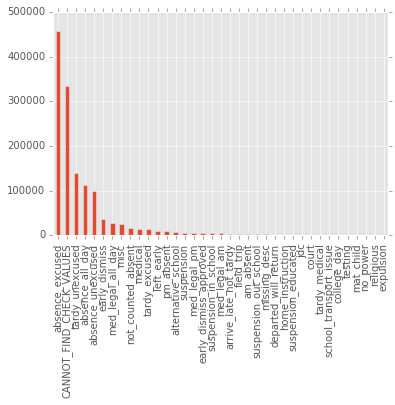

time: 1.42 s


In [12]:
absences['absence_desc'].value_counts().plot(kind='bar')

withdraws = withdraw_reason[pd.notnull(withdraw_reason['withdraw_reason'])]
dropouts = withdraws[withdraws['withdraw_reason'].str.contains('dropout')]
transfers = withdraws[withdraws['withdraw_reason'].str.contains('transfer')]
graduates = withdraws[withdraws['withdraw_reason'].str.contains('grad')]
print("{0} grads, {1} dropouts, {2} transfers".format(len(graduates.index), len(dropouts.index),len(transfers.index)))